In [1]:
import sys
sys.path.append('../..')
from utilities.data_manager import ExchangeDataManager
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import Trix
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:

class super_reversion_strat():
    def __init__(
        self,
        df_list,
        oldest_pair,
        parameters_obj,
        use_short=True, 
        position_limit=False,
        max_loss=0.0,
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.parameters_obj = parameters_obj
        self.use_short = use_short
        self.position_limit = position_limit
        self.max_loss = max_loss
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            params = self.parameters_obj[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            df['stoch_rsi'] = ta.momentum.stochrsi(close=df['close'], window=14)
            trix = Trix(close=df['close'],trixLength=params["trix_window"], trixSignal=params["signal_window"])
            df['trix_histo'] = trix.trix_histo()
            df['ma_long']=ta.trend.sma_indicator(close=df['close'], window=params["long_ma"])

            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []
        data_open_short = []
        data_close_short = []

        for pair in self.df_list:
            params = self.parameters_obj[pair]
            df = self.df_list[pair]
            # -- Initiate populate --
            df["open_long_limit"] = False
            df["close_long_limit"] = False
            df["open_short_limit"] = False
            df["close_short_limit"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            # -- Populate open long limit --
            df.loc[
                   (df['trix_histo'] >= 0) 
                   & (df['stoch_rsi'] < 0.8)
                   & (df['ma_long'] < df['close'])
                , "open_long_limit"
            ] = True
            
            # -- Populate close long limit --
            df.loc[
                (df['trix_histo'] < 0) 
                & (df['stoch_rsi'] > 0.2)
                , "close_long_limit"
            ] = True
            
            if self.use_short:
                # -- Populate open short limit --
                df.loc[
                    (df['trix_histo'] <= 0) 
                    & (df['stoch_rsi'] > 0.2)
                    & (df['ma_long'] > df['close'])
                    , "open_short_limit"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['trix_histo'] > 0) 
                    & (df['stoch_rsi'] < 0.8)
                    , "close_short_limit"
                ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long_limit']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long_limit']  == True) 
                ]['pair']
            )
            data_open_short.append(
                df.loc[
                (df['open_short_limit']  == True) 
                ]['pair']
            )
            data_close_short.append(
                df.loc[
                (df['close_short_limit']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        data_open_short.append(self.df_list[self.oldest_pair]['null'])
        data_close_short.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        df_open_short = pd.concat(data_open_short, axis=1)
        df_open_short['combined']= df_open_short.values.tolist()
        df_open_short['combined'] = [[i for i in j if i == i] for j in list(df_open_short['combined'])]
        df_close_short = pd.concat(data_close_short, axis=1)
        df_close_short['combined']= df_close_short.values.tolist()
        df_close_short['combined'] = [[i for i in j if i == i] for j in list(df_close_short['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        self.open_short_obj = df_open_short['combined']
        self.close_short_obj = df_close_short['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long_limit"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long_limit"]==True]))
            print("Open SHORT length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_short_limit"]==True]))
            print("Close SHORT length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_short_limit"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        usd_pct_remaining = 1
        long_pct_size = 0
        short_pct_size = 0
        maker_fee = 0.0002
        taker_fee = 0.0004
        trades = []
        days = []
        levier = 4
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pos in current_positions:
                    actual_row = self.df_list[pos].loc[index]
                    if current_positions[pos]['side'] == "LONG":
                        close_price = actual_row['close']
                        trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']*levier
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_positions[pos]['size'] - fee
                    elif current_positions[pos]['side'] == "SHORT":
                        close_price = actual_row['close']
                        trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']*levier
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_positions[pos]['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day 
            
            
            close_long_row = self.close_long_obj.loc[index]
            close_short_row = self.close_short_obj.loc[index]
            if len(current_positions) > 0:
                # -- Check Stop Loss --
                if self.max_loss > 0:
                    for pos in current_positions.copy():
                        actual_row = self.df_list[pos].loc[index]
                        if current_positions[pos]['side'] == "LONG":
                            if actual_row['low'] < current_positions[pos]['stop_loss']:
                                close_price = current_positions[pos]['stop_loss']
                                trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']*levier
                                close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                                fee = close_size * taker_fee
                                wallet += close_size - current_positions[pos]['size'] - fee
                                usd_remaining += close_size - fee
                                usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                                trades.append({
                                    "pair": pos,
                                    "open_date": current_positions[pos]['date'],
                                    "close_date": index,
                                    "position": current_positions[pos]['side'],
                                    "open_reason": current_positions[pos]['reason'],
                                    "close_reason": "Stop Loss",
                                    "open_price": current_positions[pos]['price'],
                                    "close_price": close_price,
                                    "open_fee": current_positions[pos]['fee'],
                                    "close_fee": fee,
                                    "open_trade_size":current_positions[pos]['size'],
                                    "close_trade_size":close_size,
                                    "wallet": wallet,
                                    "usd_remaining": usd_remaining
                                })
                                if self.position_limit: long_pct_size -= self.parameters_obj[pos]['wallet_exposure']
                                del current_positions[pos]  

                        elif current_positions[pos]['side'] == "SHORT":
                            if actual_row['high'] > current_positions[pos]['stop_loss']:
                                close_price = current_positions[pos]['stop_loss']
                                trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']*levier
                                close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                                fee = close_size * taker_fee
                                wallet += close_size - current_positions[pos]['size'] - fee
                                usd_remaining += close_size - fee
                                usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                                trades.append({
                                    "pair": pos,
                                    "open_date": current_positions[pos]['date'],
                                    "close_date": index,
                                    "position": current_positions[pos]['side'],
                                    "open_reason": current_positions[pos]['reason'],
                                    "close_reason": "Stop Loss",
                                    "open_price": current_positions[pos]['price'],
                                    "close_price": close_price,
                                    "open_fee": current_positions[pos]['fee'],
                                    "close_fee": fee,
                                    "open_trade_size":current_positions[pos]['size'],
                                    "close_trade_size":close_size,
                                    "wallet": wallet,
                                    "usd_remaining": usd_remaining
                                })
                                if self.position_limit: short_pct_size -= self.parameters_obj[pos]['wallet_exposure']
                                del current_positions[pos]

                # -- Close LONG market --
                long_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "LONG"}).intersection(set(close_long_row))
                for pos in long_position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']*levier
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Limit",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    if self.position_limit: long_pct_size -= self.parameters_obj[pos]['wallet_exposure']
                    del current_positions[pos]   
                    
                # -- Close SHORT market --
                short_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "SHORT"}).intersection(set(close_short_row))
                for pos in short_position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']*levier
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Limit",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    if self.position_limit: short_pct_size -= self.parameters_obj[pos]['wallet_exposure']
                    del current_positions[pos]   
                    
            # -- Check for opening position --
            # -- Open LONG market --
            if long_pct_size <= 0.5:
                open_long_row = self.open_long_obj.loc[index]
                if len(open_long_row) > 0:
                    for pos in open_long_row:
                        if pos not in current_positions:
                            actual_row = self.df_list[pos].loc[index]
                            open_price = actual_row['close']
                            pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                            usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                            fee = pos_size * taker_fee
                            pos_size -= fee
                            wallet -= fee
                            usd_remaining -= pos_size+fee
                            stop_loss_price = open_price - ((self.max_loss / self.parameters_obj[pos]['wallet_exposure']) * open_price)
                            current_positions[pos] = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee":fee,
                                "reason": "Limit",
                                "side": "LONG",
                                "stop_loss": stop_loss_price,
                            }
                            if self.position_limit: long_pct_size += self.parameters_obj[pos]['wallet_exposure']
            # -- Open SHORT market --
            if short_pct_size <= 0.5:
                open_short_row = self.open_short_obj.loc[index]
                if len(open_short_row) > 0:
                    for pos in open_short_row:
                        if pos not in current_positions:
                            actual_row = self.df_list[pos].loc[index]
                            open_price = actual_row['close']
                            pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                            usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                            fee = pos_size * taker_fee
                            pos_size -= fee
                            wallet -= fee
                            usd_remaining -= pos_size+fee
                            stop_loss_price = open_price + ((self.max_loss / self.parameters_obj[pos]['wallet_exposure']) * open_price)
                            current_positions[pos] = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee":fee,
                                "reason": "Limit",
                                "side": "SHORT",
                                "stop_loss": stop_loss_price,
                            }
                            if self.position_limit: short_pct_size += self.parameters_obj[pos]['wallet_exposure']
                        
                        
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }  


In [3]:
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 16,
        "long_ma": 840
    },
    "ETH/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 10,
        "signal_window": 43,
        "long_ma": 600
    },
    "ADA/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 5,
        "signal_window": 21,
        "long_ma": 480
    },
    "XRP/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 15,
        "signal_window": 15,
        "long_ma": 100
    },
    "BNB/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 9,
        "signal_window": 12,
        "long_ma": 120
    },
    "APT/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 15,
        "signal_window": 18,
        "long_ma": 360
    },
    "SOL/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 9,
        "signal_window": 12,
        "long_ma": 280
    },
    "AVAX/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 14,
        "signal_window": 20,
        "long_ma": 420
    },
    "DOT/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 21,
        "long_ma": 780
    },
    "MATIC/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 18,
        "long_ma": 100
    },
    "NEAR/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 28,
        "signal_window": 22,
        "long_ma": 800
    },
    "FTM/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 6,
        "signal_window": 17,
        "long_ma": 900
    },
    "ETC/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 9,
        "signal_window": 19,
        "long_ma": 180
    },
    "DOGE/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 20,
        "long_ma": 100
    },
    "FIL/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 10,
        "signal_window": 25,
        "long_ma": 180
    },
    "SAND/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 14,
        "signal_window": 39,
        "long_ma": 660
    },
    "1000SHIB/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 18,
        "long_ma": 160
    },
    "GALA/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 6,
        "signal_window": 22,
        "long_ma": 240
    },
    "TLM/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 25,
        "long_ma": 200
    },
    "DYDX/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 15,
        "long_ma": 920
    },
    "EGLD/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 17,
        "long_ma": 120
    },
    "AXS/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 13,
        "signal_window": 22,
        "long_ma": 800
    },
    "FET/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 14,
        "long_ma": 840
    },
    "RUNE/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 3,
        "signal_window": 27,
        "long_ma": 100
    },
    "JASMY/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 10,
        "signal_window": 20,
        "long_ma": 820
    },
    "ROSE/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 15,
        "long_ma": 900
    },
    "OP/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 29,
        "signal_window": 11,
        "long_ma": 100
    },
    "MANA/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 10,
        "signal_window": 20,
        "long_ma": 580
    },
    "LDO/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 11,
        "long_ma": 100
    },
    "MINA/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 22,
        "long_ma": 500
    },
    "ZIL/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 28,
        "signal_window": 42,
        "long_ma": 200
    },
    "FLOW/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 11,
        "signal_window": 25,
        "long_ma": 760
    },
    "KLAY/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 5,
        "signal_window": 10,
        "long_ma": 360
    },
    "SKL/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 16,
        "long_ma": 840
    },
    "REEF/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 5,
        "signal_window": 38,
        "long_ma": 800
    },
    "GRT/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 11,
        "signal_window": 46,
        "long_ma": 820
    },
    "OCEAN/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 20,
        "long_ma": 660
    },
    "ANKR/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 9,
        "signal_window": 25,
        "long_ma": 780
    },
    "BAKE/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 26,
        "long_ma": 920
    },
    "ENJ/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 12,
        "long_ma": 620
    },
    "AAVE/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 7,
        "signal_window": 17,
        "long_ma": 240
    },
    "RNDR/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 11,
        "signal_window": 27,
        "long_ma": 140
    },
    "CHR/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 13,
        "long_ma": 300
    },
    "ACH/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 13,
        "long_ma": 300
    },
    "STORJ/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 11,
        "signal_window": 19,
        "long_ma": 100
    },
    "WOO/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 23,
        "long_ma": 660
    },
    "STX/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 13,
        "signal_window": 21,
        "long_ma": 800,
    },
    "ONE/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 8,
        "signal_window": 16,
        "long_ma": 840
    },
    "ATOM/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 14,
        "signal_window": 45,
        "long_ma": 400
    },
    "CFX/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 15,
        "trix_window": 9,
        "signal_window": 16,
        "long_ma": 100
    }
}

if sum(d["wallet_exposure"] for d in params_coin.values() if d) > 1.01:
    raise ValueError("Wallet exposure must be less or equal than 1 not {}".format(sum(d["wallet_exposure"] for d in params_coin.values() if d)))

pair_list = list(params_coin.keys())
tf = '1h'
oldest_pair = "BTC/USDT"

df_list = {}
exchange = ExchangeDataManager(exchange_name="binanceusdm", path_download="../database/exchanges")
for pair in pair_list:
    df = exchange.load_data(coin=pair, interval="1h")       
    df_list[pair] = df.loc['2022':]

print("Data load 100%")
df_list[oldest_pair]

/Users/rg37147/repos/backtest_tools/backtest/multi_division/../../utilities/data_manager.py:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True)
/Users/rg37147/repos/backtest_tools/backtest/multi_division/../../utilities/data_manager.py:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True)
/Users/rg37147/repos/backtest_tools/backtest/multi_division/../../utilities/data_manager.py:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index

Data load 100%


/Users/rg37147/repos/backtest_tools/backtest/multi_division/../../utilities/data_manager.py:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True)


,open,high,low,close,volume
date,,,,,
2022-01-01 00:00:00,46210.57,46729.73,46210.55,46650.01,8957.465
2022-01-01 01:00:00,46650.00,46944.56,46570.34,46766.78,7276.249
2022-01-01 02:00:00,46767.44,46917.87,46709.44,46796.14,4478.713
2022-01-01 03:00:00,46796.15,46888.00,46746.32,46789.56,4208.992
2022-01-01 04:00:00,46789.55,46868.74,46605.00,46690.81,6149.298
...,...,...,...,...,...
2023-11-14 16:00:00,36168.80,36449.00,36138.40,36289.80,16477.987
2023-11-14 17:00:00,36289.70,36347.10,36087.10,36119.90,14020.733
2023-11-14 18:00:00,36120.00,36158.20,34446.30,35239.50,79685.715


In [4]:
params_coin.keys()

dict_keys(['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'XRP/USDT', 'BNB/USDT', 'APT/USDT', 'SOL/USDT', 'AVAX/USDT', 'DOT/USDT', 'MATIC/USDT', 'NEAR/USDT', 'FTM/USDT', 'ETC/USDT', 'DOGE/USDT', 'FIL/USDT', 'SAND/USDT', '1000SHIB/USDT', 'GALA/USDT', 'TLM/USDT', 'DYDX/USDT', 'EGLD/USDT', 'AXS/USDT', 'FET/USDT', 'RUNE/USDT', 'JASMY/USDT', 'ROSE/USDT', 'OP/USDT', 'MANA/USDT', 'LDO/USDT', 'MINA/USDT', 'ZIL/USDT', 'FLOW/USDT', 'KLAY/USDT', 'SKL/USDT', 'REEF/USDT', 'GRT/USDT', 'OCEAN/USDT', 'ANKR/USDT', 'BAKE/USDT', 'ENJ/USDT', 'AAVE/USDT', 'RNDR/USDT', 'CHR/USDT', 'ACH/USDT', 'STORJ/USDT', 'WOO/USDT', 'STX/USDT', 'ONE/USDT', 'ATOM/USDT', 'CFX/USDT'])

Period: [2022-01-01 00:00:00] -> [2023-11-14 00:00:00]
Initial wallet: 1000.0 $
Trades on 50 pairs

--- General Information ---
Final wallet: 126916.69 $
Performance vs US dollar: 12591.67 %
Sharpe Ratio: 2.72
Worst Drawdown T|D: -50.37% | -48.37%
Buy and hold performance: -22.25 %
Performance vs buy and hold: 16223.73 %
Total trades on the period: 23545
Global Win rate: 45.1 %
Average Profit: 1.31 %

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-trade    Worst-trade     Best-trade       Win-rate
-----------------------------------------------------------------------------------------------
640   MATIC/USDT       784.49 %         1.23 %       -68.06 %       138.56 %        47.03 %
616    DOGE/USDT       763.51 %         1.24 %       -80.02 %       120.33 %        45.94 %
1039   RUNE/USDT      1671.75 %         1.61 %       -80.02 %       107.69 %        43.31 %
680     BNB

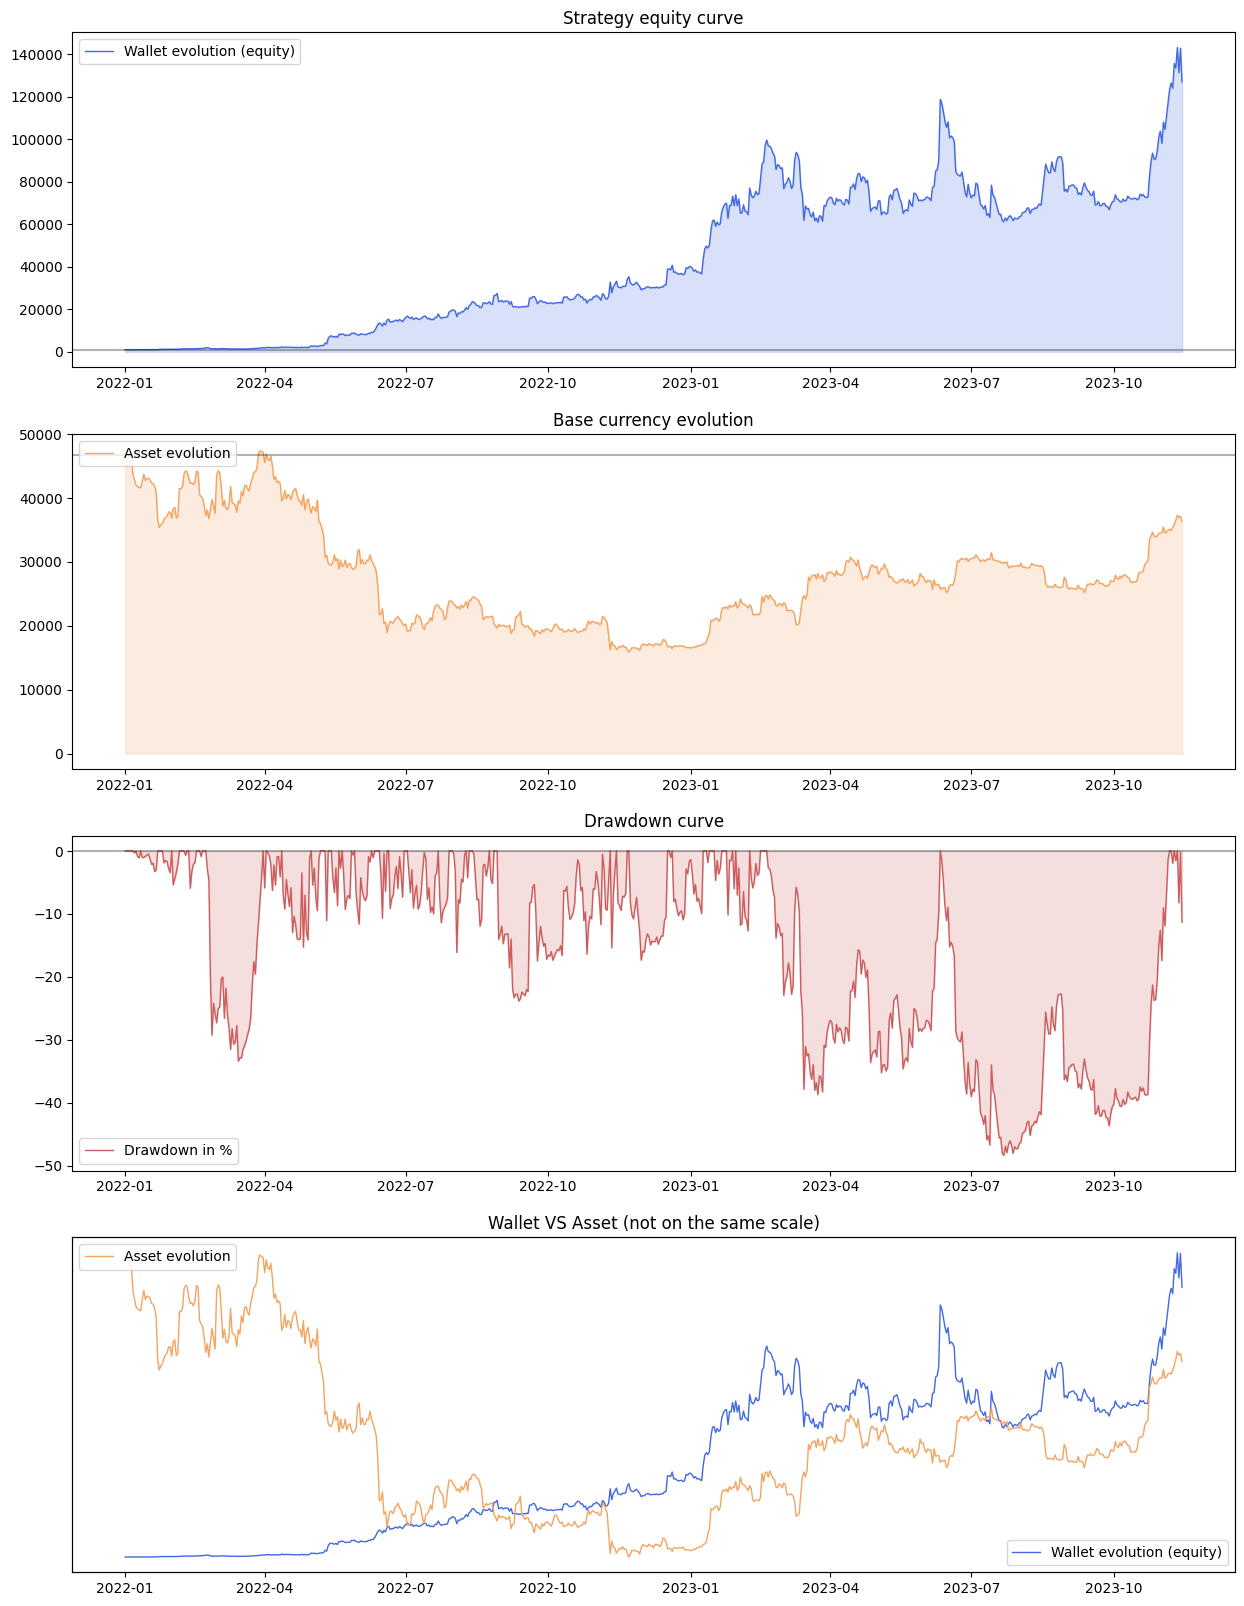

In [5]:
strat = super_reversion_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin,
    use_short=True,
    position_limit=False,
    max_loss=0.004
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=False)
bt_result = strat.run_backtest(initial_wallet=1000)

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

In [6]:
df_trades

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,usd_remaining,trade_result,trade_result_pct,trade_result_pct_wallet,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2022-01-05 03:00:00,MATIC/USDT,2022-01-05 03:00:00,2022-01-05 10:00:00,SHORT,Limit,Limit,2.41520,2.42810,0.008000,0.007826,19.992000,19.564877,999.549051,979.557051,-0.442949,-0.022147,-0.000443,999.549051,0.000000,0.000000
2022-01-05 03:00:00,DOGE/USDT,2022-01-05 03:00:00,2022-01-05 10:00:00,SHORT,Limit,Limit,0.16980,0.16994,0.008000,0.007970,19.992000,19.926066,999.475147,999.475147,-0.081904,-0.004095,-0.000082,999.549051,0.073904,0.000074
2022-01-05 10:00:00,RUNE/USDT,2022-01-05 10:00:00,2022-01-05 13:00:00,LONG,Limit,Limit,8.11800,7.99700,0.007996,0.007516,19.981507,18.790198,998.268326,998.268326,-1.206821,-0.060373,-0.001210,999.549051,1.280725,0.001281
2022-01-06 05:00:00,BNB/USDT,2022-01-06 05:00:00,2022-01-06 09:00:00,SHORT,Limit,Limit,468.95000,460.97000,0.007986,0.008526,19.957380,21.315819,999.570321,899.783419,1.341926,0.067213,0.001341,999.570321,0.000000,0.000000
2022-01-06 05:00:00,EGLD/USDT,2022-01-06 05:00:00,2022-01-06 09:00:00,SHORT,Limit,Limit,207.58000,201.82000,0.007986,0.008869,19.957380,22.172517,1001.776588,921.947067,2.198281,0.110105,0.002190,1001.776588,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-14 15:00:00,STX/USDT,2023-11-14 15:00:00,2023-11-14 20:00:00,LONG,Limit,Limit,0.63600,0.61630,1.012676,0.886851,2530.677011,2217.127721,122180.162114,42533.457183,-315.448817,-0.124600,-0.002589,141352.435652,19172.273538,0.135635
2023-11-14 09:00:00,ROSE/USDT,2023-11-14 09:00:00,2023-11-14 20:00:00,LONG,Limit,Limit,0.07188,0.06842,1.030080,0.831413,2574.170720,2078.531839,121683.691820,44611.157609,-497.500374,-0.193189,-0.004105,141352.435652,19668.743832,0.139147
2023-11-14 06:00:00,GALA/USDT,2023-11-14 06:00:00,2023-11-14 20:00:00,LONG,Limit,Limit,0.02242,0.02201,1.017370,0.942573,2542.407813,2356.433289,121496.774723,46966.648326,-187.934467,-0.073890,-0.001549,141352.435652,19855.660928,0.140469


----- 2022 Cumulative Performances: 3904.56% -----


/Users/rg37147/repos/backtest_tools/backtest/multi_division/../../utilities/backtesting.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)


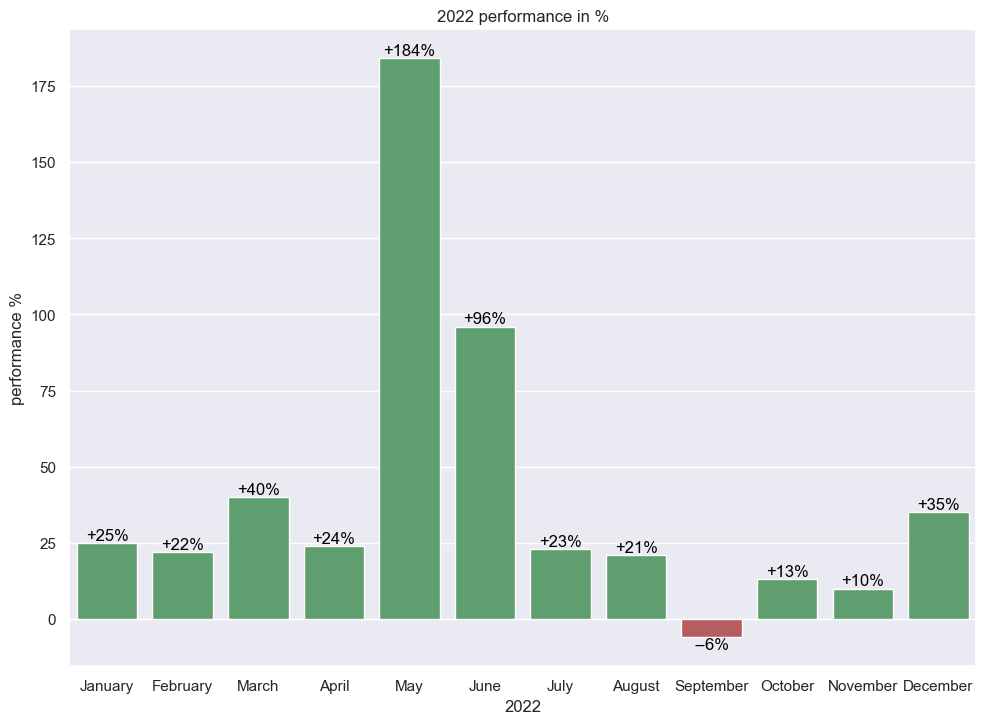

/Users/rg37147/repos/backtest_tools/backtest/multi_division/../../utilities/backtesting.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)


----- 2023 Cumulative Performances: 216.1% -----


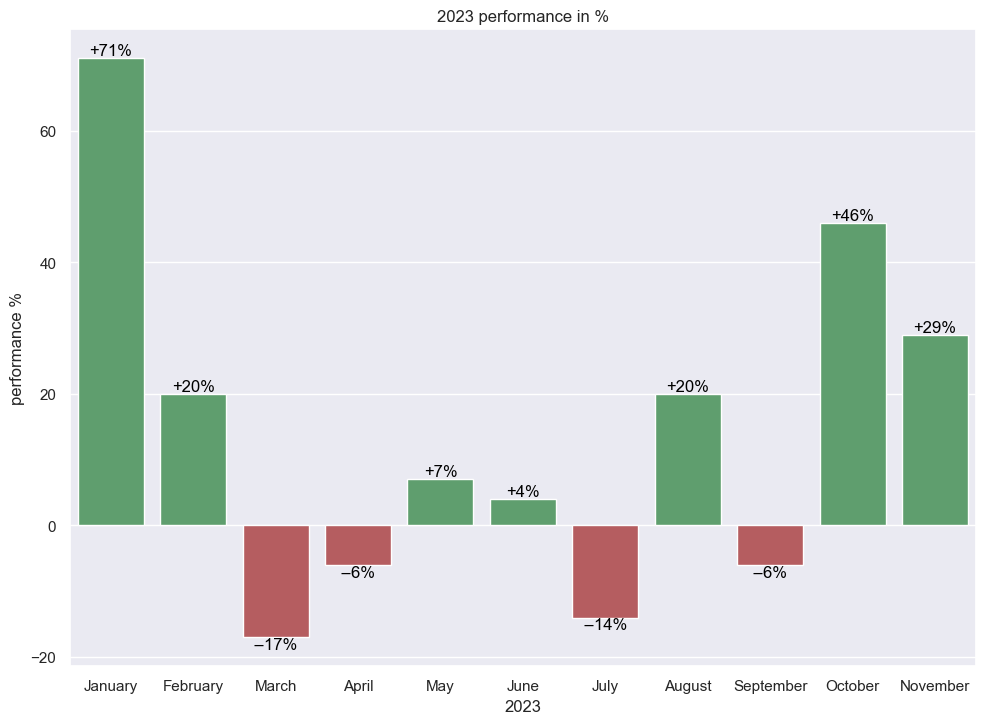

In [7]:
plot_bar_by_month(df_days)